# 序列数据
- 实际中很多数据是有时序结构的
- 电影的评价随时间变化而变化
- 拿奖后评分上升，直到奖项被忘记
- 看了很多好电影后，人们的期望变高
- 季节性:贺岁片、暑期档
- 导演、演员的负面报道导致评分变低

# 统计工具

·在时间$t$观察到$x_t$,那么得到$T$个不独立的随机变量
$$(x_1,...x_T)\sim p(\mathbf{x})$$
· 使用条件概率展开
$$p(a,b)=p(a)p(b|a)=p(b)p(a|b)$$

$$p(\mathbf{x})=p(x_1)\cdot p(x_2|x_1)\cdot p(x_3|x_1,x_2)\cdot...p(x_T|x_1,...x_{T-1})$$

### · 对条件概率建模
$$p(x_t|x_1,...x_{t-1})=p(x_t|f(x_1,...x_{t-1}))$$
对见过的数据建模，也称自回归模型

### 方案A-马尔科夫假设
$$p(\mathbf{x})=p(x_1)\cdot p(x_2|x_1)\cdot p(x_3|x_1,x_2)\cdot...p(x_T|x_1,...x_{T-1})$$
·假设当前当前数据只跟\tau 个过去数据点相关
$$p(x_t|x_1,\ldots x_{t-1})=p(x_t|x_{t-\tau},\ldots x_{t-1})=p(x_t|f(x_{t-\tau},\ldots x_{t-1}))$$

### 方案 B- 潜变量模型
$$p(\mathbf{x})=p(x_1)\cdot p(x_2|x_1)\cdot p(x_3|x_1,x_2)\cdot...p(x_T|x_1,...x_{T-1})$$
·引人潜变量$h_t$来表示过去信息$h_t=f(x_1,...x_{t-1})$

·这样$x_t=p(x_t|h_t)$

# 总结
- 时序模型中，当前数据跟之前观察到的数据相关
- 自回归模型使用自身过去数据来预测未来
- 马尔科夫模型假设当前只跟最近少数数据相关，从而简化模型
- 潜变量模型使用潜变量来概括历史信息

# 序列模型
使用正弦函数和一些可加性噪声来生成序列数据，时间步为1,2....，1000

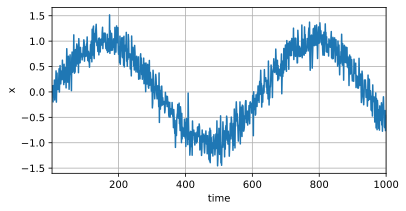

In [1]:
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l

T = 1000
time = torch.arange(1, T + 1, dtype=torch.float32)
x = torch.sin(0.01 * time) + torch.normal(0, 0.2, (T,))
d2l.plot(time, [x], 'time', 'x', xlim=[1, 1000], figsize=(6, 3))

将数据映射为数据对$y_t=x_t$和$\mathbf{x}_t=[x_{t-\tau},\ldots,x_{t-1}]$

In [2]:
tau = 4
features = torch.zeros((T - tau, tau))
for i in range(tau):
    features[:, i] = x[i: T - tau + i]
labels = x[tau:].reshape((-1, 1))
batch_size, n_train = 16, 600
train_iter = d2l.load_array((features[:n_train], labels[:n_train]),
                            batch_size, is_train=True)

使用一个相当简单的结构：只是一个拥有两个全连接层的多层感知机

In [5]:
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)


def get_net():
    net = nn.Sequential(nn.Linear(4, 10),
                        nn.ReLU(),
                        nn.Linear(10, 1))
    net.apply(init_weights)
    return net


loss = nn.MSELoss()

训练模型

In [6]:
def train(net, train_iter, loss, epochs, lr):
    trainer = torch.optim.Adam(net.parameters(), lr)
    for epoch in range(epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            trainer.step()
        print(f'epoch {epoch + 1}',
              f'loss {d2l.evaluate_loss(net, train_iter, loss):f}')


net = get_net()
train(net, train_iter, loss, 5, 0.01)

epoch 1 loss 0.064466
epoch 2 loss 0.053520
epoch 3 loss 0.051987
epoch 4 loss 0.049829
epoch 5 loss 0.049022


模型预测下一个时间步

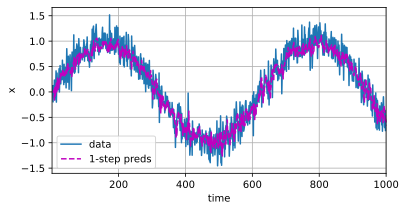

In [10]:
onestep_preds = net(features)
d2l.plot(
    [time, time[tau:]],
    [x.detach().numpy(), onestep_preds.detach().numpy()], 'time', 'x',
    legend=['data', '1-step preds'],
    xlim=[1, 1000],
    figsize=(6, 3)
)

进行多步预测

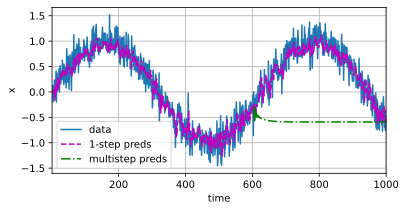

In [12]:
multistep_preds = torch.zeros((T,))
multistep_preds[:n_train + tau] = x[:n_train + tau]
for i in range(n_train + tau, T):
    multistep_preds[i] = net(multistep_preds[i - tau:i].reshape((1, -1)))

d2l.plot([time, time[tau:], time[n_train + tau:]],
         [x.detach().numpy(), onestep_preds.detach().numpy(), multistep_preds[n_train + tau:].detach().numpy()], 'time',
         'x', legend=['data', '1-step preds', 'multistep preds'], xlim=[1, 1000], figsize=(6, 3))

更仔细地看一下k步预测

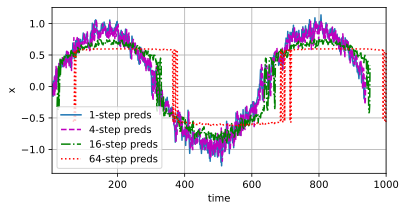

In [14]:
max_steps = 64

features = torch.zeros((T - tau - max_steps + 1, tau + max_steps))
for i in range(tau):
    features[:, i] = x[i: i + T - tau - max_steps + 1]

for i in range(tau, tau + max_steps):
    features[:, i] = net(features[:, i - tau:i]).reshape(-1)

steps = (1, 4, 16, 64)
d2l.plot([time[tau + i - 1: T - max_steps + i] for i in steps],
         [features[:, (tau + i - 1)].detach().numpy() for i in steps], 'time', 'x',
         legend=[f'{i}-step preds' for i in steps], xlim=[5, 1000],
         figsize=(6, 3))